# Part2 BlobDetector
Author: Victor Badenas Crespo

## Purpose
Case study of the different effects of different corner detectors.

## Methodology
Modifying the example in [the scikit-image corner detection example](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_corner.html#sphx-glr-auto-examples-features-detection-plot-corner-py), the [corner detectors in the scikit image package](https://scikit-image.org/docs/stable/api/skimage.feature.html) are tested. 

Images from the [general purpose images of scikit-image](https://scikit-image.org/docs/stable/auto_examples/data/plot_general.html) will be used to evaluate and explain the advantages and disadvantages of those corner detectors.

***
## Setup

### Library import
We import all the required Python libraries

In [1]:
import skimage
import numpy as np
import ipywidgets as widgets

from skimage import data, color, io
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
from pprint import pprint
from math import sqrt
from ipywidgets import interact, interactive, fixed, interact_manual

### Local library import and functions
We import all the required local libraries and user defined functions and utilities

In [2]:
def plotImages(images, grid=(2, 2), figsize=(15, 9), **kwargs):
    f, ax = plt.subplots(grid[0], grid[1], figsize=figsize)
    for imageIdx, (title, image) in enumerate(images.items()):
        cmap = plt.cm.gray if image.ndim == 2 else None
        if grid[0] == 1:
            ax[imageIdx].set_title(title)
            ax[imageIdx].imshow(image, cmap=cmap, **kwargs)
            ax[imageIdx].axis('off')
        else:
            ax[imageIdx//grid[1]][imageIdx%grid[1]].set_title(title)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].imshow(image, cmap=cmap, **kwargs)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].axis('off')
    return f, ax

***
## Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [3]:
# skimage data image list
images = {
    'astronaut': None,
    'binary_blobs': None,
    'brick': None,
    'colorwheel': None,
    'camera': None,
    'cat': None,
    'checkerboard': None,
    'clock': None,
    'coffee': None,
    'coins': None,
    'eagle': None,
    'grass': None,
    'gravel': None,
    'horse': None,
    'hubble_deep_field': None,
    'page': None,
    'text': None,
    'rocket': None
}


In [4]:
# corner extraction method's functions
methods = {
    "blob_dog": blob_dog, 
    "blob_log": blob_log, 
    "blob_doh": blob_doh
}

***
## Data import
We retrieve all the required data for the analysis.

In [5]:
# load all data images
for imageName in images:
    images[imageName] = getattr(data, imageName)()

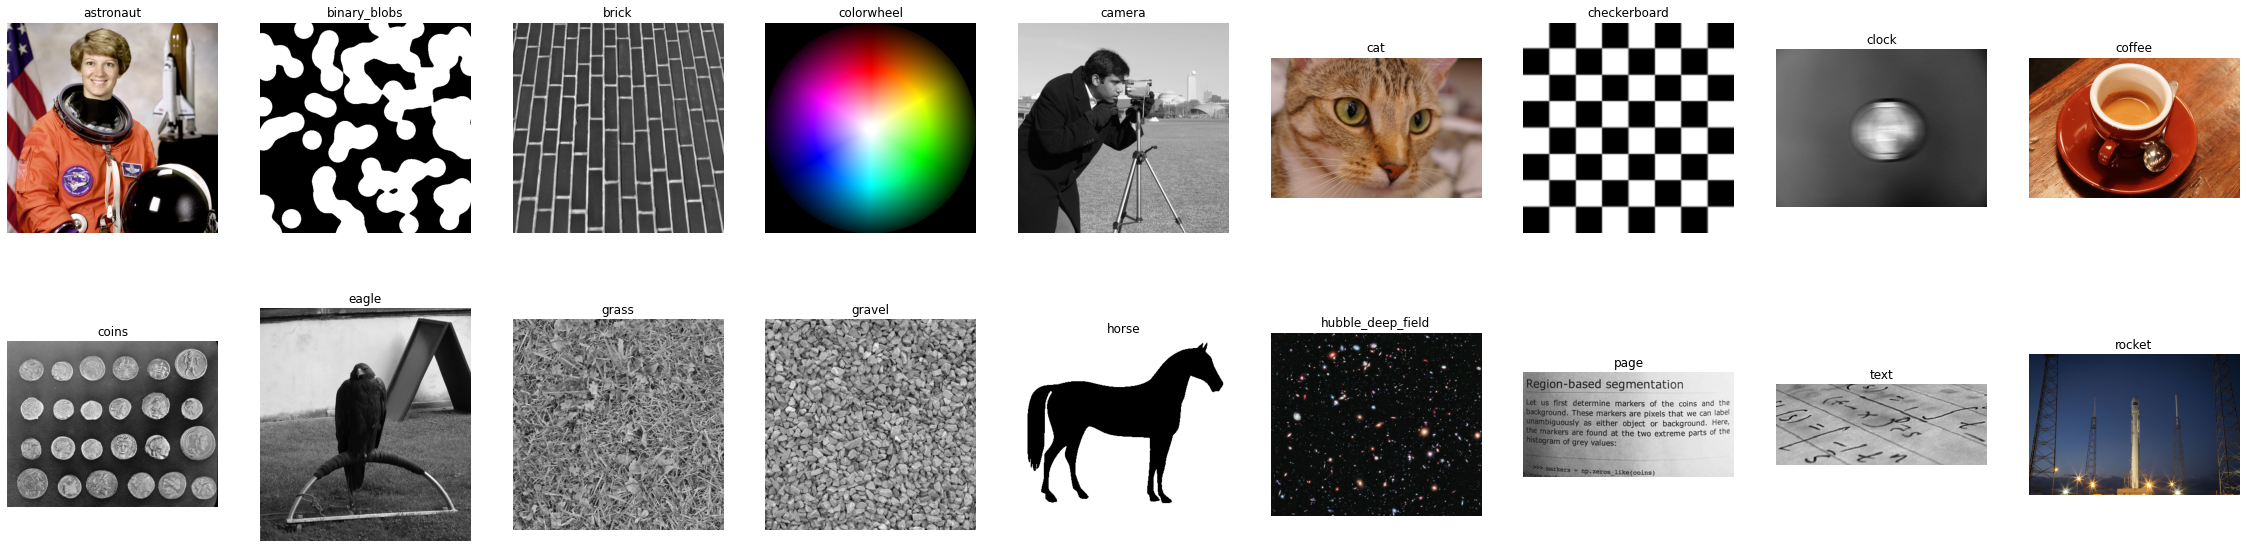

In [6]:
# plot all data images loaded in the previous cell
plotImages(images, grid=(2, int(len(images)/2)), figsize=(40, 10))
plt.show()

***
## Data processing

In [15]:
@interact(imageName=list(images.keys()))
def blob_detection(imageName='exampleImage'):
    image = images[imageName]
    image_gray = image if image.ndim <= 2 else rgb2gray(image)

    blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

    blobs_list = [blobs_log, blobs_dog, blobs_doh]
    colors = ['yellow', 'lime', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']

    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    ax = axes.ravel()
    cmap = 'gray' if image.ndim == 2 else None

    for idx, (blobs, color, title) in enumerate(zip(blobs_list, colors, titles)):
        ax[idx].set_title(title)
        ax[idx].imshow(image, cmap=cmap)
        for blob in blobs:
            y, x, r = blob
            c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
            ax[idx].add_patch(c)
        ax[idx].set_axis_off()

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='imageName', options=('astronaut', 'binary_blobs', 'brick', 'colorw…

***

## Discussion


***
## References
We report here relevant references:

1. The scikit-image corner detection example, https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_corner.html#sphx-glr-auto-examples-features-detection-plot-corner-py
2. Corner detectors in the scikit image package, https://scikit-image.org/docs/stable/api/skimage.feature.html
3. General purpose images of scikit-image, https://scikit-image.org/docs/stable/auto_examples/data/plot_general.html
4. Viswanathan, Deepak. “Features from Accelerated Segment Test ( FAST ).” (2011).
5. Derpanis, K. G. (2004). The harris corner detector. York University, 2.